# [개념 필사]

## CHAPTER 07 <앙상블 학습과 랜덤 포레스트>

> 앙상블 학습 - 가장 좋은 모델 "1개" 보다 더 나은 예측을 얻을 수 있음 (대중의 지혜, 앙상블 방법) / 1개의 예측기보다 편향은 비슷하지만 분산 감소. (결정 경계 덜 불규칙적)

> 랜덤 포레스트 - 결정 트리의 앙상블

## **7.1 투표 기반 분류기**

◾**직접 투표** 분류기: 여러 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측. (다수결 투표)

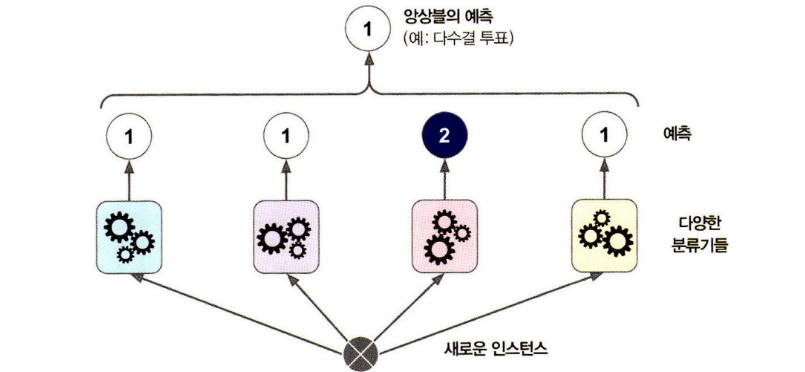

* 약한 학습기들 => 많고, 다양 => 강한 학습기 (앙상블)
* 큰 수의 법칙: 실험 반복 횟수가 커질수록 그 표본 평균이 모평균에 가까워진다는 원리.
* 가정: 모든 분류기들이 독립적, 오차에 상관관계가 없어야함. / 최대한 독립적일 때 최고의 성능
```
voting = "hard"
```

◾**간접 투표** 분류기: 모든 분류기가 클래스의 확률을 예측 가능 할 때 (predict_proba()가능), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측.

* 직접 투표 보다 성능 ⬆
```
voting = "soft"
```

* SVC 에서는
```
probability = True
```

## **7.2 배깅과 페이스팅**

◾**배깅** : 훈련 세트에서 중복을 허용하여 샘플링하는 앙상블 방식.

* 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 가능



◾**페이스팅** : 훈련 세트에서 중복을 허용하지 않고 샘플링하는 앙상블 방식.

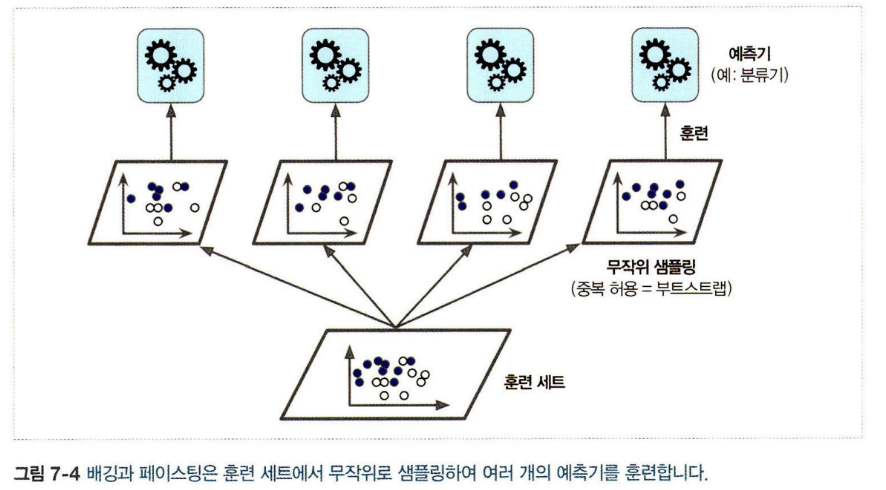

▶ 모든 예측기 훈련 끝, 예측을 수집(분류 - 최빈값, 회귀 - 평균)하여 새로운 샘플에 대한 예측 생성

▶ 전반적으로 배깅이 페이스팅 보다 나음. (시간, CPU 여유 있으면 둘다 시도해보고 선택)


## 7.2.1 사이킷런의 배깅과 페이스팅

🖥 BaggingClassifier, BaggingRegressor
```
bootstrap=True (배깅, 디폴트)

bootstrap=False (페이스팅 지정)

n_jobs = -1(가용한 모든 코어 사용, CPU 코어 수 지정)
```

## 7.2.2 oob 평가

* 배깅은 중복 허용 => 선택되지 않는 훈련 샘플이 생김 (37% 정도)

* **oob (out-of-bag): 선택되지 않는 나머지 37%의 훈련 샘플**

▶ 별도의 검증 샘플 대신, oob로 성능을 평가. (각 예측기의 oob 평가를 평균하여 계산)
```
oob_score = True (훈련 끝난 후, 자동으로 oob 평가 수행)

평가 점수 결과 : oob_score_

oob 샘플에 대한 결정 함수 값: oob_decision_function_ (각 훈련 샘플의 클래스 확률 반환)
```

## **7.3 랜덤 패치와 랜덤 서브스페이스**

🖥 BaggingClassifier (BaggingRegressor) - **특성에 대한 샘플링 지원**

🖥 max_features, bootstrap_features 로 조절 (max_samples, bootstrap과 작동 방식 동일)


◾ 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링 하는 것.

* 고차원 데이터셋 다룰 때 유용.
* 특성 샘플링은 더 다양한 예측기를 생성, 편향 증가, 분산 감소

◾ 랜덤 서브 스페이스 방식: 훈련 샘플을 모두 사용하고 특성을 샘플링하는 것.

⏬ 코드 설정 방법
```
샘플

boostrap = False & max_sample=1.0
```
```
특성
bootstrap_features=True & max_features < 1.0 으로 설정
```

## **7.4 랜덤 포레스트**

◾ **랜덤 포레스트**: 배깅 (페이스팅)을 적용한 결정 트리의 앙상블.

🖥 RandomForestClassifier (RandomForestRegressor)

🖥 max_samples - 훈련세트 크기로 지정

## 7.4.1 엑스트라 트리

◾ **익스트림 랜덤 트리**: 극단적으로 무작위한 트리의 랜덤포레스트

* 그냥 랜덤포레스트보다 훨씬 빠른 속도.

🖥 ExtraTreesClassifier (ExtraTreesRegressor) - 랜덤포레스트와 사용법 동일


## 7.4.2 특성 중요도

* 랜덤포레스트, 특성의 상대적 중요도 측정이 용이함.

* 사이킷런, 자동으로 점수 계산 => 전체 합 1로 결괏값 정규화.

```
feature_importances_
```




# [코드 필사]

In [11]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

# 5장에서의 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
## 투표 기반 분류기 생성, 훈련

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [21]:
## 각 분류기의 정확도 확인

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.95
SVC 0.95
VotingClassifier 0.9


In [17]:
## 결정 트리 분류기 500개 앙상블 훈련 (배깅)

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [18]:
## oob 평가

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [22]:
## 테스트 세트에서의 정확도 확인 => oob랑 비슷

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [23]:
bag_clf.oob_decision_function_

array([[0.1010101 , 0.8989899 ],
       [0.        , 1.        ],
       [0.96517413, 0.03482587],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.78421053, 0.21578947],
       [1.        , 0.        ],
       [0.00520833, 0.99479167],
       [0.01630435, 0.98369565],
       [1.        , 0.        ],
       [0.89830508, 0.10169492],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.98159509, 0.01840491],
       [0.96428571, 0.03571429],
       [1.        , 0.        ],
       [0.3715847 , 0.6284153 ],
       [1.        , 0.        ],
       [0.98333333, 0.01666667],
       [0.40449438, 0.59550562],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.98901099, 0.01098901],
       [0.43367347, 0.56632653],
       [0.        , 1.        ],
       [0.00558659, 0.99441341],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [24]:
## 500개 트리로 이뤄진 랜덤포레스트 분류기 훈련

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [25]:
## BaggingClassifier 사용해서 랜덤포레스트 구현

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

In [26]:
## 특성 중요도 출력

from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09807699134048424
sepal width (cm) 0.025509045140202604
petal length (cm) 0.43226983625211063
petal width (cm) 0.4441441272672024
